Dolphin数据集是 D.Lusseau 等人使用长达 7 年的时间观察新西兰 Doubtful Sound海峡 62 只海豚群体的交流情况而得到的海豚社会关系网络。这个网络具有 62 个节点，159 条边。节点表示海豚，边表示海豚间的频繁接触

数据文件：dolphins.gml

1）对Dolphin 关系进行Graph Embedding，使用GCN

2）对Embedding进行可视化（使用PCA呈现在二维平面上）

In [2]:
import numpy as np
import networkx as nx
from networkx import to_numpy_matrix
import matplotlib.pyplot as plt

In [5]:
# 数据读取
G = nx.read_gml('/content/drive/MyDrive/dolphins/dolphins.gml')

In [7]:
print('节点数：',len(list(G.nodes())))
print('边数：',len(list(G.edges())))

节点数： 62
边数： 159


In [13]:
# 对网络G进行可视化
def plot_graph(G):
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    nx.draw_networkx(G, pos, edgelist=edges);
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_size=200, node_color='r', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=edges,alpha =0.4)
    plt.show()

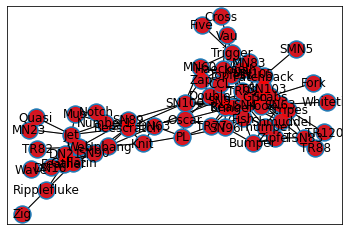

In [14]:
plot_graph(G)

In [16]:
# 邻接矩阵
A = sorted(list(G.nodes()))

In [17]:
A = to_numpy_matrix(G, A)
A

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

In [18]:
A_hat = A + np.eye(A.shape[0])
A_hat

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 1.]])

In [19]:
D = np.array(A_hat.sum(axis=0))[0] * np.eye(A_hat.shape[0])
D

array([[7., 0., 0., ..., 0., 0., 0.],
       [0., 9., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 6., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [23]:
def Laplace(G):
    '''拉普拉斯算子'''
    # 节点按顺序排
    nodes = sorted(list(G.nodes()))
    # 构建邻接矩阵
    A = to_numpy_matrix(G, nodelist=nodes)
    # 考虑节点自身
    I = np.eye(A.shape[0])
    A_hat = A + I
    # 度矩阵
    D_hat = np.array(A_hat.sum(axis=0))[0] * I + 1e-5
    # print(D_hat)
    # 归一化
    L = D_hat**(-1) * A_hat
    return L

In [24]:
# 由于图确定了，L也就是固定的，因此先提前计算好
L = Laplace(G)

In [25]:
# 随机初始化权重
W_1 = np.random.normal(loc=0, scale=1, size=(L.shape[0], L.shape[0]//2))
W_2 = np.random.normal(loc=0, scale=1, size=(L.shape[0]//2, 2))

In [26]:
# 两层GCN
I = np.eye(L.shape[0])
y_1 = L*I*W_1 
y_2 = L*y_1*W_2
output = y_2

In [27]:
# 提取特征表征
feature_representations = {}
nodes = list(G.nodes())
for i in range(len(nodes)):             # G.number_of_nodes()
    feature_representations[nodes[i]] = np.array(output)[i]
print('feature_representations=\n', feature_representations)

feature_representations=
 {'Beak': array([-2.14947305e+15,  8.05121514e+14]), 'Beescratch': array([-2.13749322e+15,  8.01378879e+14]), 'Bumper': array([-2.16093449e+15,  8.09946592e+14]), 'CCL': array([-2.16682592e+15,  8.12388994e+14]), 'Cross': array([-2.17878523e+15,  8.17242427e+14]), 'DN16': array([-2.16165573e+15,  8.10446370e+14]), 'DN21': array([-2.15047309e+15,  8.06047006e+14]), 'DN63': array([-2.15472840e+15,  8.08160629e+14]), 'Double': array([-2.14957893e+15,  8.06027088e+14]), 'Feather': array([-2.14483966e+15,  8.03505207e+14]), 'Fish': array([-2.15501078e+15,  8.07331173e+14]), 'Five': array([-2.17859047e+15,  8.17233024e+14]), 'Fork': array([-2.17830159e+15,  8.17446223e+14]), 'Gallatin': array([-2.13898932e+15,  8.01296821e+14]), 'Grin': array([-2.11527804e+15,  7.93597894e+14]), 'Haecksel': array([-2.14353811e+15,  8.04752322e+14]), 'Hook': array([-2.15013268e+15,  8.06912784e+14]), 'Jet': array([-2.13309931e+15,  7.99253679e+14]), 'Jonah': array([-2.14385345e+15,  8

In [28]:
# 绘制output，节点GCN embedding可视化
def plot_node(output, title):
    for i in range(len(nodes)):
        node_name = nodes[i]
        # 以散点图的方式描绘
        plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label=str(i),alpha=0.5,s = 250)
        plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i,                 # 给每个点标记，即海豚
                 horizontalalignment='center',verticalalignment='center', 
                 fontdict={'color':'black'})
    plt.title(title)
    plt.show()

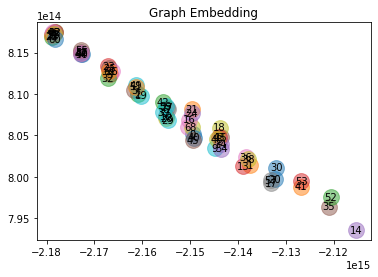

In [29]:
plot_node(output, 'Graph Embedding')